# Eval WEAC

Initialize models, run over a resolution of 5cm with a standardized weak layer.


In [1]:
# Auto reload modules
%load_ext autoreload
%autoreload all

In [2]:
import os
from typing import List
import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
from pprint import pprint
import copy
from tqdm.notebook import tqdm

from weac_2.analysis import Analyzer, CriteriaEvaluator, CoupledCriterionResult
from weac_2.core.system_model import SystemModel
from weac_2.components import ModelInput, Segment, ScenarioConfig, WeakLayer, Layer, CriteriaConfig
from weac_2.utils.snowpilot_parser import SnowPilotParser, convert_to_mm, convert_to_deg

In [3]:
number_of_files = 1

# Process multiple files
file_paths = []
for directory in os.listdir("data/snowpits"):
    for file in os.listdir(f"data/snowpits/{directory}"):
        if file.endswith(".xml"):
            file_paths.append(f"data/snowpits/{directory}/{file}")

paths: List[str] = []
parsers: List[SnowPilotParser] = []

for file_path in file_paths[:number_of_files]:
    snowpilot_parser = SnowPilotParser(file_path)
    paths.append(file_path)
    parsers.append(snowpilot_parser)

print(f"\nFound {len(paths)} files")


Found 1 files


In [4]:
# Setup standard values
wl_spacing = 50 # mm
standard_scenario_config = ScenarioConfig(system_type="skier", phi=0.0)
standard_weak_layer = WeakLayer(rho=125, h=20, E=1.0)
standard_segments = [
    Segment(length=10000, has_foundation=True, m=0.0),
    Segment(
        length=10000,
        has_foundation=True,
        m=0.0,
    ),
]
standard_criteria_config = CriteriaConfig()
standard_criteria_evaluator = CriteriaEvaluator(standard_criteria_config)

In [5]:
# Collect errors
error_paths = {}
error_values = {}

data_rows = []
for i, (file_path, parser) in tqdm(
    enumerate(zip(paths, parsers)), total=len(paths), desc="Processing files"
):
    # Extract layers
    layers, density_method = parser.extract_layers()
    heights = np.cumsum([layer.h for layer in layers])
    # space evenly and append the last height
    wl_depths = np.arange(wl_spacing, heights[-1], wl_spacing).tolist()
    wl_depths.append(heights[-1])
    
    layers_copy = copy.deepcopy(layers)
    for i, wl_depth in tqdm(enumerate(wl_depths), total=len(wl_depths), desc="Processing weak layers", leave=False):
        # only keep layers above the spacing
        mask = heights <= wl_depth
        new_layers = [layer for layer, keep in zip(layers_copy, mask) if keep]
        # Add truncated layer if needed
        depth = np.sum([layer.h for layer in new_layers]) if new_layers else 0.0
        if depth < wl_depth:
            additional_layer = copy.deepcopy(layers_copy[len(new_layers)-1 if new_layers else 0])
            additional_layer.h = wl_depth - depth
            new_layers.append(additional_layer)
        
        model_input = ModelInput(
            weak_layer=standard_weak_layer,
            layers=new_layers,
            scenario_config=standard_scenario_config,
            segments=standard_segments,
        )
        system = SystemModel(model_input=model_input)
        
        result: CoupledCriterionResult = standard_criteria_evaluator.evaluate_coupled_criterion(system)
        print("ImpactCriterion: ", result.initial_critical_skier_weight)
        print("CoupledCriterion: ", result.critical_skier_weight)

        data_rows.append({
            "wl_depth": wl_depth,
            "impact_criterion": result.initial_critical_skier_weight,
            "coupled_criterion": result.critical_skier_weight,
        })


Processing files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing weak layers:   0%|          | 0/60 [00:00<?, ?it/s]

ImpactCriterion:  12.786378092968118
CoupledCriterion:  17.216283714103174
ImpactCriterion:  18.53403292312249
CoupledCriterion:  24.237631553914845
ImpactCriterion:  22.9033928863141
CoupledCriterion:  29.52566626184025
ImpactCriterion:  26.399504046224678
CoupledCriterion:  33.88776912979537
ImpactCriterion:  29.360417154435577
CoupledCriterion:  37.63484360466431
ImpactCriterion:  77.74892998578854
CoupledCriterion:  97.28999223004385
ImpactCriterion:  81.43767162846154
CoupledCriterion:  102.30309264664731
ImpactCriterion:  84.68441059032683
CoupledCriterion:  106.79477416884568
ImpactCriterion:  87.56528752196559
CoupledCriterion:  110.7748720973868
ImpactCriterion:  90.54641519196804
CoupledCriterion:  114.27011204417977
ImpactCriterion:  92.33084998192145
CoupledCriterion:  117.39469713994725
ImpactCriterion:  148.7289355533121
CoupledCriterion:  187.74214028521334
ImpactCriterion:  151.08729427112166
CoupledCriterion:  190.35062534472547
ImpactCriterion:  151.9605451046871
Coup

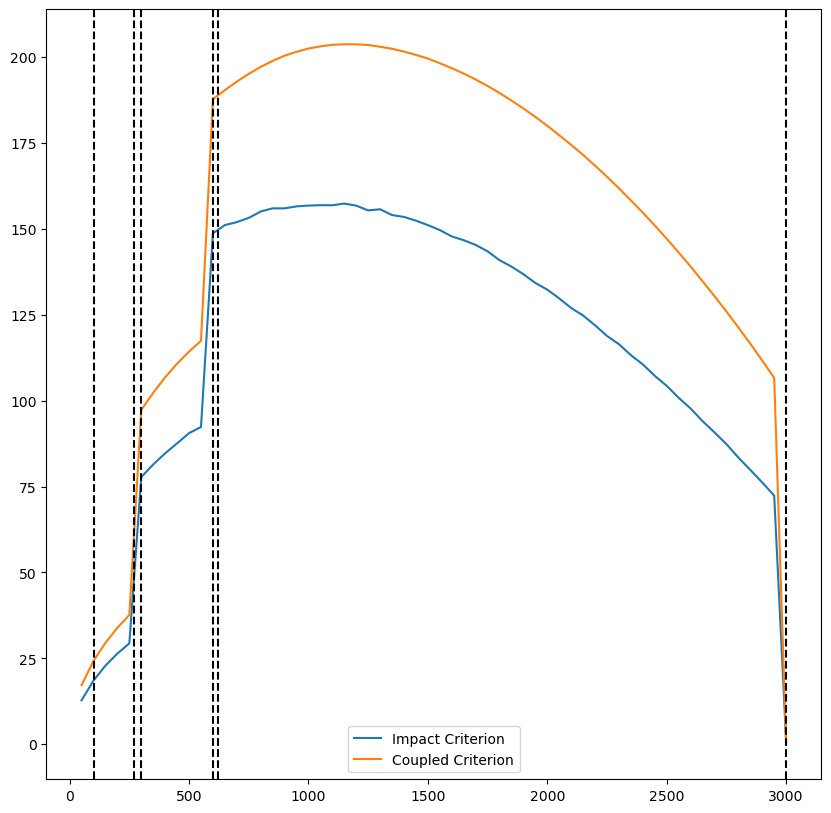

In [6]:
import matplotlib.pyplot as plt
dataframe = pd.DataFrame(data_rows)
plt.figure(figsize=(10, 10))
plt.plot(dataframe["wl_depth"], dataframe["impact_criterion"], label="Impact Criterion")
plt.plot(dataframe["wl_depth"], dataframe["coupled_criterion"], label="Coupled Criterion")
# plot vertical lines at the end of each layer
for i, height in enumerate(heights):
    plt.axvline(x=height, color="black", linestyle="--")
plt.legend()
plt.show()